In [1]:
from InferenceRESTful import networks
from InferenceRESTful import image_processing


ModuleNotFoundError: No module named 'InferenceRESTful'

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import os
from PIL import Image
import numpy as np
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from photo_wct import PhotoWCT
import process_stylization

In [4]:
class Model:
    def __init__(self, base_model = 'unet_256', gpu_ids = [0]):
        self.gpu_ids = gpu_ids
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        print("Using device", self.device)
        self.netG = networks.define_G(3, 3, 64, netG = base_model, gpu_ids = self.gpu_ids)
        print("Network Initialized")
        
    def load_networks(self, save_dir="checkpoints/edge2shoes_cyclegan/", epoch = 'latest', name ='G'):
        """Load all the networks from the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)
        
    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    def print_networks(self, verbose=False):
        """Print the total number of parameters in the network and (if verbose) network architecture

        Parameters:
            verbose (bool) -- if verbose: print the network architecture
        """
        print('---------- Networks initialized -------------')
        
        num_params = 0
        for param in self.netG.parameters():
            num_params += param.numel()
        if verbose:
            print(self.netG)
        print('[Network %s] Total number of parameters : %.3f M' % ('G', num_params / 1e6))  
        print('-----------------------------------------------')
        
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

def processImage(img, opt = {'crop_size':256, 'no_flip':False, 'load_size':256,'preprocess':'resize_and_crop'}):
        transform_params = image_processing.get_params(opt, A.size)
        A_transform = image_processing.get_transform(opt, transform_params, grayscale=False)
        _A = A_transform(A)
        return _A

In [5]:
isinstance(B, torch.Tensor)

NameError: name 'B' is not defined

In [6]:
model = Model()
model.load_networks()

Using device cuda:0
initialize network with normal
Network Initialized
loading the model from checkpoints/edge2shoes_cyclegan/latest_net_G.pth


In [7]:
model.print_networks()

---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
-----------------------------------------------


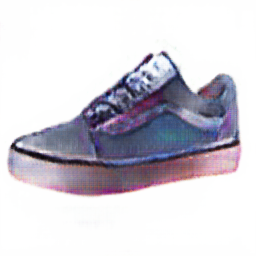

In [3]:
A = Image.open('content2.png').convert('RGB')
A

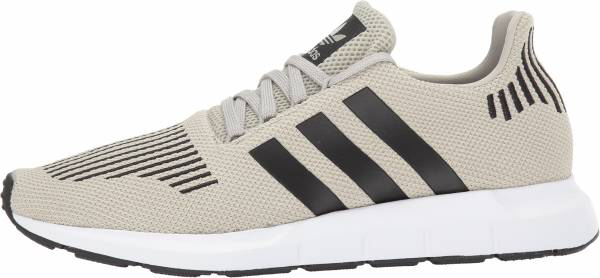

In [4]:
style = Image.open('style.jpg').convert('RGB')
style

In [5]:

# Load model
p_wct = PhotoWCT()
p_wct.load_state_dict(torch.load('./PhotoWCTModels/photo_wct.pth'))
p_wct.cuda(0)

PhotoWCT(
  (e1): VGGEncoder(
    (conv0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (pad1_1): ReflectionPad2d((1, 1, 1, 1))
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu1_1): ReLU(inplace)
  )
  (d1): VGGDecoder(
    (pad1_1): ReflectionPad2d((1, 1, 1, 1))
    (conv1_1): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (e2): VGGEncoder(
    (conv0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (pad1_1): ReflectionPad2d((1, 1, 1, 1))
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu1_1): ReLU(inplace)
    (pad1_2): ReflectionPad2d((1, 1, 1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu1_2): ReLU(inplace)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pad2_1): ReflectionPad2d((1, 1, 1, 1))
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu2_1): ReLU(inplace)
  )
  (d2): VGGDecoder(
    (pad2_1): ReflectionPa

In [6]:
from process_stylization import *

In [7]:
from photo_smooth import Propagator
p_pro = Propagator()

In [9]:
out = stylization(
    stylization_module=p_wct,
    smoothing_module=p_pro,
    cont_img=A,
    styl_img=style,
    cuda=1,
    save_intermediate=False,
    no_post=False
)

Resize image: (256,256)->(256,256)
Resize image: (600,278)->(600,278)
Elapsed time in stylization: 0.398862
Elapsed time in propagation: 8.032969
Elapsed time in post processing: 0.273219


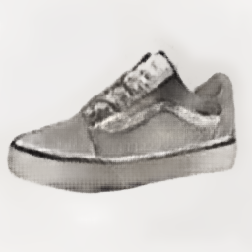

In [10]:
out

In [20]:
B = processImage(A)
B = B.reshape((1, B.shape[0], B.shape[1], B.shape[2]))

In [27]:
import pickle 
import requests as re
import json

In [28]:
data = {'data':pickle.dumps(B).hex(), 'transformed':True ,'user':'ashish', 'type':'vanilla', 'modelname':'e2s'}

In [29]:
r = re.post('http://127.0.0.1:5000/generate', data = json.dumps(data))

In [30]:
r

<Response [200]>

In [31]:
h = json.loads(r.text)
j = pickle.loads(bytes.fromhex(h))

In [17]:
(not isinstance(B, torch.Tensor))

False

In [21]:
#x = torch.zeros(1, 3, 256, 256, dtype=torch.float, requires_grad=False)
out = model.netG(B)
#make_dot(out)

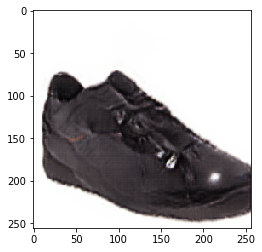

In [22]:
output = tensor2im(out)
plt.imshow(output)